In [1]:
import os
from snn_delays.config import CHECKPOINT_PATH
from snn_delays.utils.model_loader import ModelLoader
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from snn_delays.utils.results_utils import get_results_refact

ckpt_dir = 'abl1_shd50_refact_new_weight_init'

# delays
sweep_params_names = {
    'structure':['mf', 'r', 'rd'],
    'tau_m':['fx', 'st', 'lt'],
    }

acc, spk, _, _ = get_results_refact(ckpt_dir, sweep_params_names, rpts=5)
_, _, trnloss, tstloss = get_results_refact(ckpt_dir, sweep_params_names, rpts=5, mode='last')

num_neurons: 64


In [3]:
def plot_boxplots(df):
    sns.set_theme(style="whitegrid")
    # Create the boxplot with customizations
    
    boxplot = sns.boxplot(data=df, palette="Set3")  # Use a color palette to add color

    # Rotate x-axis labels for readability
    plt.xticks(rotation=45, ha='right', fontsize=10, color='darkred')

    # Add a grid with custom style
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Optional: Show median labels on each box
    for i, patch in enumerate(boxplot.artists):
        median_val = df.iloc[:, i].median()
        boxplot.text(i, median_val + 0.5, f'{median_val:.1f}%', ha='center', color='black', fontsize=10)

    return plt.gca()

## Recurrent vs feedforward + delays vs multi-feedforward

Text(0, 0.5, 'Spikes per neuron per timestep')

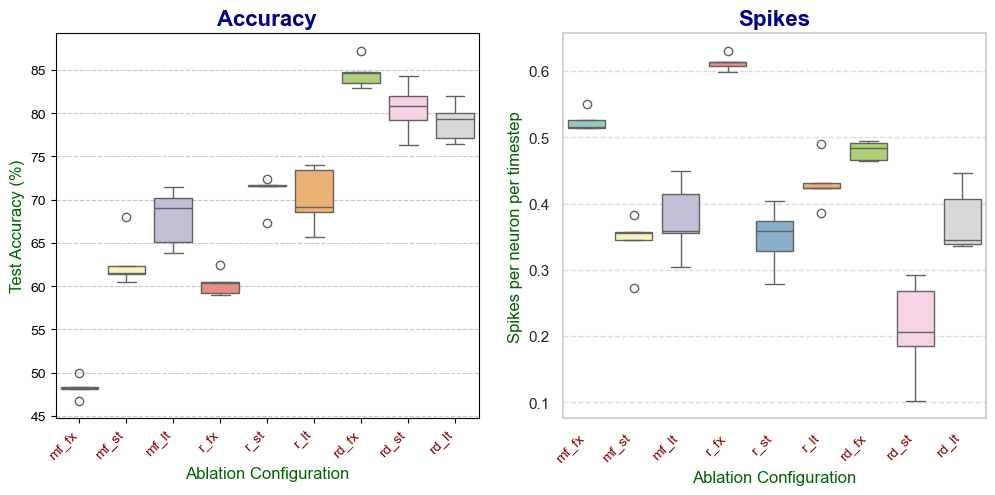

In [4]:
df_acc = pd.DataFrame(acc)
df_spk = pd.DataFrame(spk)
plt.figure(figsize=(12, 5))
plt.subplot(121)
plot_boxplots(df_acc)
plt.title("Accuracy", fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel("Ablation Configuration", fontsize=12, color='darkgreen')
plt.ylabel("Test Accuracy (%)", fontsize=12, color='darkgreen')
plt.subplot(122)
plot_boxplots(df_spk)
plt.title("Spikes", fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel("Ablation Configuration", fontsize=12, color='darkgreen')
plt.ylabel("Spikes per neuron per timestep", fontsize=12, color='darkgreen')

Learning curves

In [5]:
import numpy as np
def plot_losses(nested_loss_lists, label='Mean loss', color='blue', linestyle='-'):

    # Example data: replace `nested_loss_lists` with your actual data
    #nested_loss_lists = tstloss_d['f_d_2l_hm_ft']

    # Ensure all lists have the same length and epoch indices
    epochs = [entry[0] for entry in nested_loss_lists[0]]  # Epochs
    all_losses = [np.array([entry[1] for entry in lst]) for lst in nested_loss_lists]

    # Calculate average and standard deviation
    mean_losses = np.mean(all_losses, axis=0)
    std_losses = np.std(all_losses, axis=0)

    # Plot the average loss curve with error bars
    #plt.figure(figsize=(10, 6))
    plt.plot(epochs, mean_losses, label=label, color=color, linestyle=linestyle)
    #plt.fill_between(epochs, mean_losses - std_losses, mean_losses + std_losses, color=color, alpha=0.2, label='±1 Std Dev')
    plt.fill_between(epochs, mean_losses - std_losses, mean_losses + std_losses, color=color, alpha=0.2)
    #plt.title("Average Loss Curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(True)
    return plt.gca()

(0.0, 5.0)

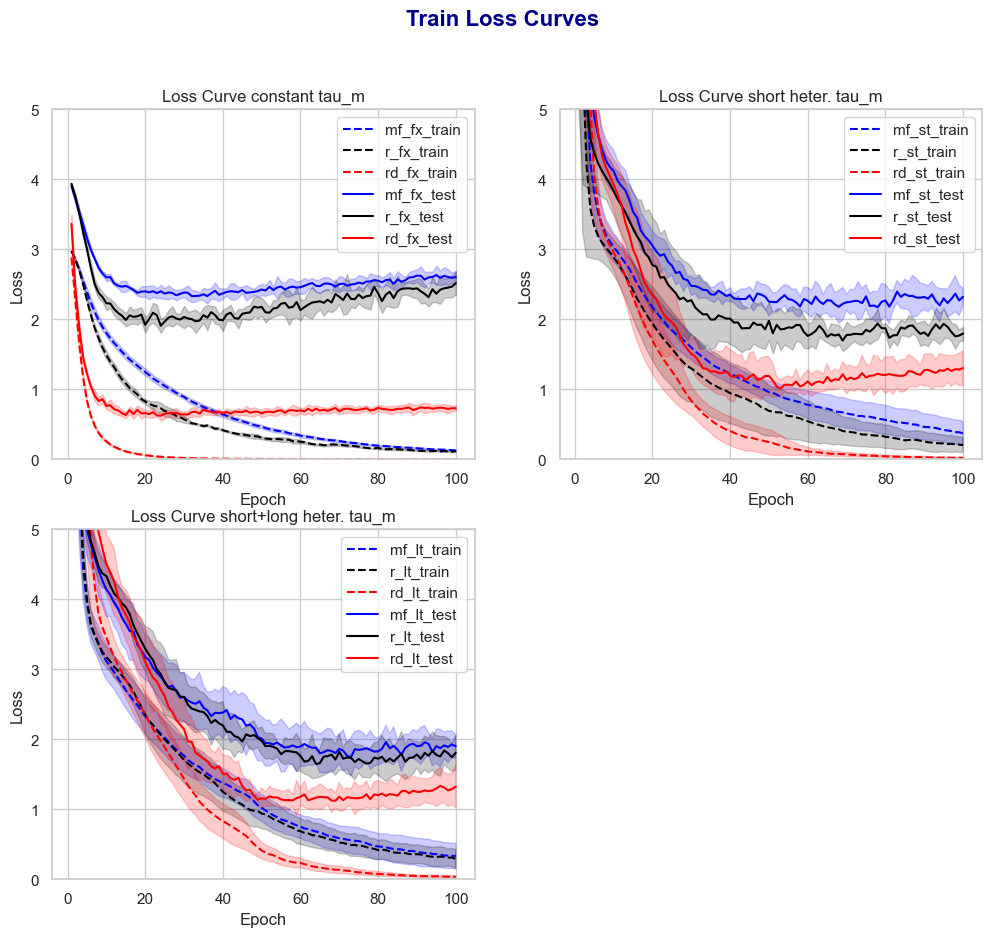

In [10]:
all_train_losses = trnloss
filtered_fx = {key:value for key, value in all_train_losses.items() if 'fx' in key}
filtered_st = {key:value for key, value in all_train_losses.items() if 'st' in key}
filtered_lt = {key:value for key, value in all_train_losses.items() if 'lt' in key}

all_test_losses = tstloss
filtered_fx_test = {key:value for key, value in all_test_losses.items() if 'fx' in key}
filtered_st_test = {key:value for key, value in all_test_losses.items() if 'st' in key}
filtered_lt_test = {key:value for key, value in all_test_losses.items() if 'lt' in key}

import itertools
colors = itertools.cycle(["blue", "black", 'red'])

ylim = 5.0

plt.figure(figsize=(12,10))
plt.suptitle('Train Loss Curves', fontsize=16, fontweight='bold', color='darkblue')
plt.subplot(221)
plt.title('Loss Curve constant tau_m')
for key, value in filtered_fx.items():
    plot_losses(value, label=key+'_train', color=next(colors), linestyle='--')
for key, value in filtered_fx_test.items():
    plot_losses(value, label=key+'_test', color=next(colors))
plt.ylim(0, ylim)

plt.subplot(222)
plt.title('Loss Curve short heter. tau_m')
for key, value in filtered_st.items():
    plot_losses(value, label=key+'_train', color=next(colors), linestyle='--')
for key, value in filtered_st_test.items():
    plot_losses(value, label=key+'_test', color=next(colors))
plt.ylim(0, ylim)

plt.subplot(223)
plt.title('Loss Curve short+long heter. tau_m')
for key, value in filtered_lt.items():
    plot_losses(value, label=key+'_train', color=next(colors), linestyle='--')
for key, value in filtered_lt_test.items():
    plot_losses(value, label=key+'_test', color=next(colors))
plt.ylim(0, ylim)

Loading delays

In [83]:
from snn_delays.utils.results_utils import get_states

attributes = ['layers']

sweep_params_names = {
    'structure':['rd'],
    'tau_m':['fx', 'st', 'lt'],
    }


layers, _, _ = get_states(ckpt_dir, sweep_params_names, attributes, rpts=5, mode='max')

returning dict_keys(['layers', 'refs', 'imgs'])


In [72]:
mask = layers['rd_fx'][0][1].pruning_mask.cpu().numpy()
weight_delays = layers['rd_fx'][0][1].linear.weight.detach().cpu().numpy()
num_out = layers['rd_fx'][0][1].num_out
num_in = layers['rd_fx'][0][1].num_in
num_delays = len(layers['rd_fx'][0][1].delays)

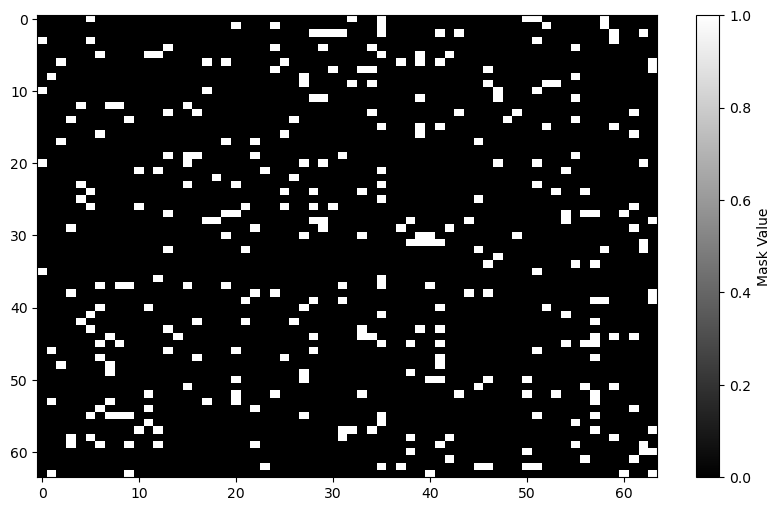

In [47]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(mask[:, :64], cmap='gray', aspect='auto')
plt.colorbar(label='Mask Value')

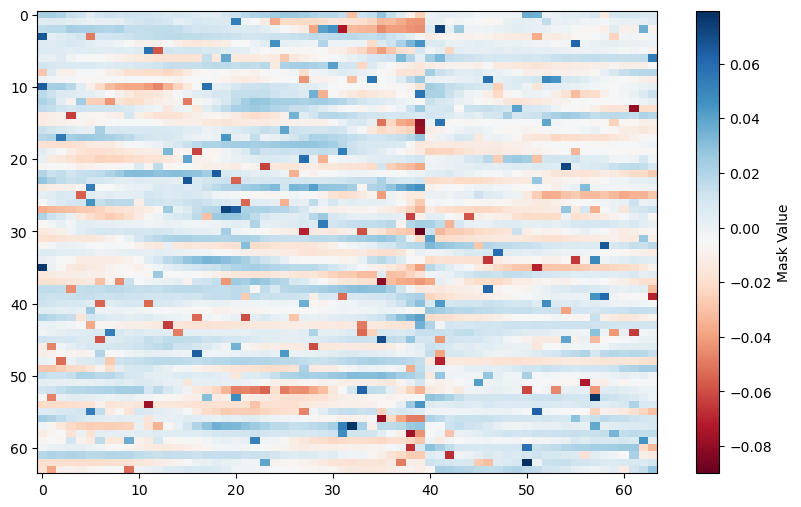

In [48]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow(weight_delays[:, :64], cmap='RdBu', aspect='auto')
plt.colorbar(label='Mask Value')

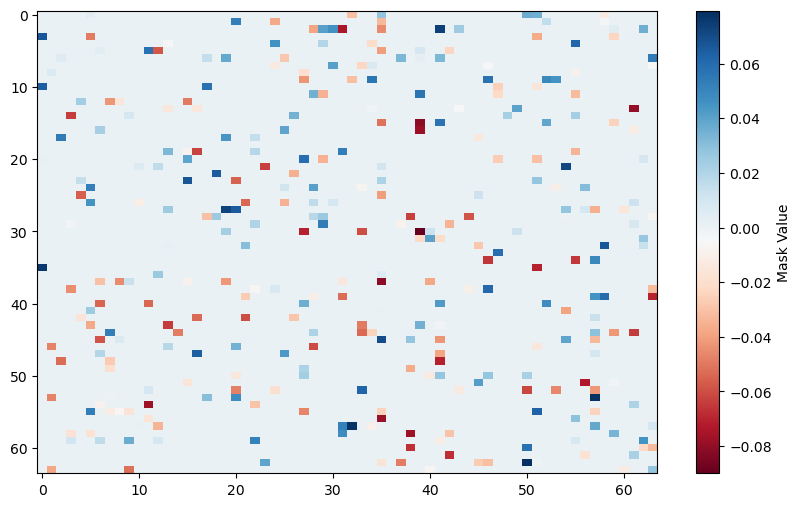

In [50]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.imshow((mask*weight_delays)[:, :64], cmap='RdBu', aspect='auto')
plt.colorbar(label='Mask Value')

In [ ]:
import numpy as np


In [84]:
def plot_delay_importance(model, N=0):
    """
    Plots the importance of each delay index based on the absolute sum of weights.
    
    Args:
        layers (dict): Dictionary containing layer information.
    """

    mask = layers[model][N][1].pruning_mask.cpu().numpy()
    weight_delays = layers[model][N][1].linear.weight.detach().cpu().numpy()
    num_out = layers[model][N][1].num_out
    num_in = layers[model][N][1].num_in
    num_delays = len(layers[model][N][1].delays)

    reshaped = (mask*weight_delays).reshape(num_out, num_in, num_delays)
    
    #importance = np.abs(reshaped).sum(axis=(0, 1))
    importance = reshaped.mean(axis=(0, 1))

    plt.figure(figsize=(10, 6))
    plt.bar(range(num_delays), importance, color='blue')
    plt.xlabel('Delay Index')
    plt.ylabel('Importance (Sum of Absolute Weights)')
    plt.title('Importance of Each Delay Index')

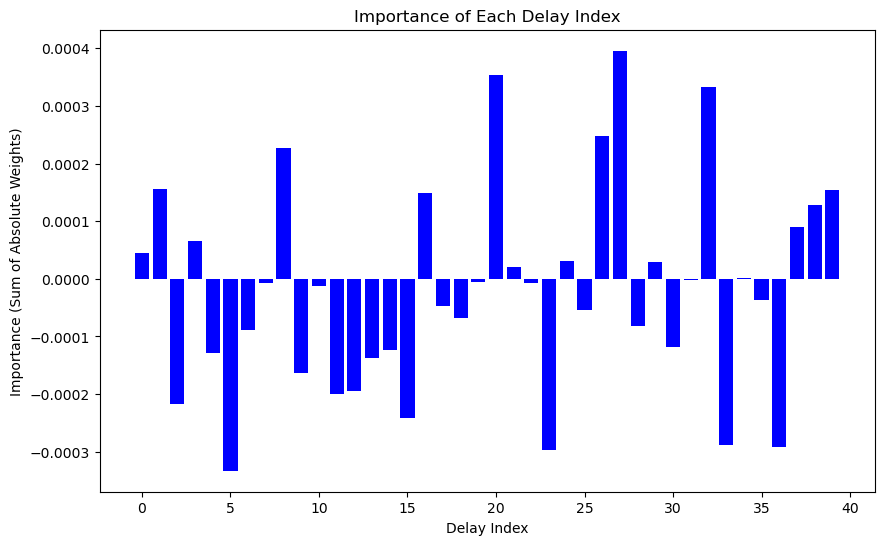

In [88]:
plot_delay_importance('rd_fx', 4)

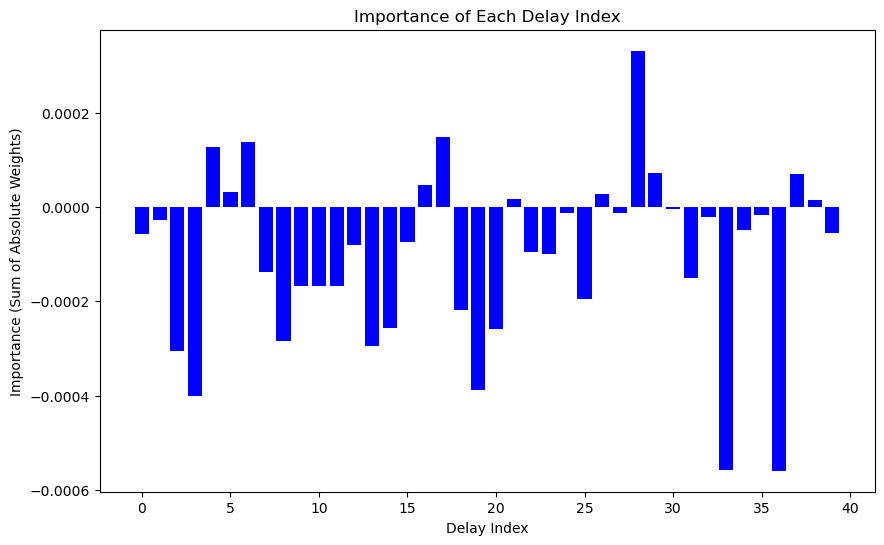

In [90]:
plot_delay_importance('rd_st', 2)

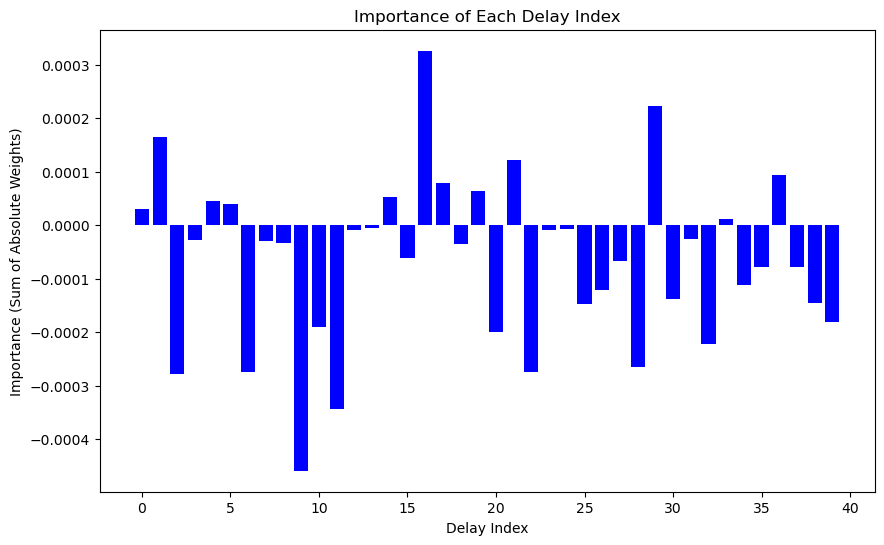

In [95]:
plot_delay_importance('rd_lt', 4)